In [189]:
import pandas as pd
import logging
import requests
from PIL import Image
import io
import matplotlib.pyplot as plt
from pathlib import Path
import h5py
import numpy as np
%matplotlib inline

#logging.getLogger("urllib3").setLevel(logging.WARNING)
#logging.basicConfig(level=logging.INFO)

In [190]:
def store_single_hdf5(image, image_id, caption):
    """ Stores a single image and its caption to an HDF5 file.
        Parameters:
        ---------------
        image       image to be stored
        image_id    integer unique ID for image
        caption       image caption
    """
    # Create a new HDF5 file
    file = h5py.File(Path('../data/img') / f"{image_id}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "image", np.shape(image), h5py.h5t.STD_U8BE, data=np.asarray(image)
    )
    meta_set = file.create_dataset(
        "caption", data=caption
    )
    
    file.close()    

In [191]:
def read_single_hdf5(image_id):
    """ Reads a single Image/Caption HDF5 file.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array stored
        label       associated meta data, int label
    """
    # Open the HDF5 file
    file = h5py.File(Path('../data/img') / f"{image_id}.h5", "r+")

    image = np.array(file["/image"]).astype("uint8")
    
    caption = np.array(file["/caption"]).astype("str")
    return image, caption

In [4]:
# Read TSV files
# Keeping it small for now
#train_df = pd.read_table('../data/Train_GCC-training.tsv', header = None, names = ['caption', 'url'] )
validate_df = pd.read_table('../data/Validation_GCC-1.1.0-Validation.tsv', header = None, names = ['caption', 'url']) 
validate_df.head(20)


,caption,url
0,author : a life in photography -- in pictures,https://i.pinimg.com/736x/66/01/6c/66016c3ba27...
1,an angler fishes river on a snowy day .,http://www.standard.net/image/2015/02/04/800x_...
2,photograph of the sign being repaired by brave...,http://indianapolis-photos.funcityfinder.com/f...
3,the player staring intently at a computer scre...,http://www.abc.net.au/news/image/9066492-3x2-7...
4,globes : the green 3d person carrying in hands...,https://www.featurepics.com/StockImage/2009031...
5,the - bedroom stone cottage can sleep people,http://i.dailymail.co.uk/i/pix/2014/11/05/1415...
6,film of a garbage truck,http://www.waste360.com/sites/waste360.com/fil...
7,young woman seated on the beach,https://media.gettyimages.com/photos/young-wom...
8,party in the park under cherry blossoms,https://worldjourneysdiscover.files.wordpress....
9,classical music 's rising stars join conducted...,http://piquemagazine.uk/wp-content/uploads/201...


In [201]:
def request_data_and_store(dataframe, size, batch_size = 5):
    """ Given a panda dataframe containing a list of urls and their corresponding caption, call 
        the urls and stores each thumbnailed-padded-to-size Image/Caption into an single hdf5 file.
        Parameters:
        ---------------
        dataframe    the pandas dataframe raw dataset
        size         the targeted size of the image in the form of a tuple (height, width)
        batch_size   future batch size...

        Returns:     
        ----------
        nothing for now...
    """

    # TODO - work with batches - For now, we will work on the batch_size-th first data of the validation dataset
    for index, row in dataframe.head(batch_size).iterrows():
        # Gets URLs
        r = requests.get(row.url)
        if (r.status_code == 200):
            print(row.url)
            img = Image.open(io.BytesIO(r.content))
            img.thumbnail(size, Image.ANTIALIAS)

            padded_image = Image.new("RGB", size)
            padded_image.paste(img, (int((size[0] - img.size[0])/2), int((size[1] - img.size[1])/2)))
            print(row.caption)
            plt.imshow(np.asarray(padded_image))
            plt.show()
            # Stores the image into a hdf5 file
            store_single_hdf5(padded_image, index, row.caption)

    return


https://i.pinimg.com/736x/66/01/6c/66016c3ba27c0e04f39e2bd81a934e3e--anita-ekberg-bob-hope.jpg
author : a life in photography -- in pictures


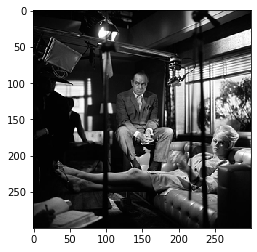

http://indianapolis-photos.funcityfinder.com/files/2009/12/Clearwater-Crossing-Shopping-Center-sign-Indianapolis-Indiana.jpg
photograph of the sign being repaired by brave person


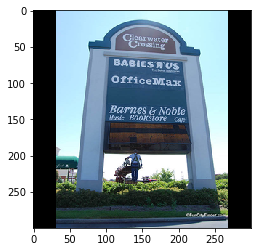

http://www.abc.net.au/news/image/9066492-3x2-700x467.jpg
the player staring intently at a computer screen .


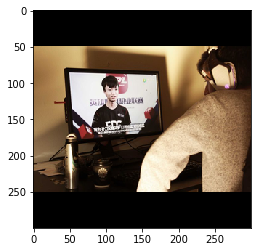

https://www.featurepics.com/StockImage/20090316/carrying-globe-stock-image-1115085.jpg
globes : the green 3d person carrying in hands globe


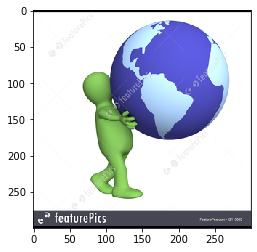

In [202]:
size = 300 , 300 
request_data_and_store(validate_df, size)  
 

In [196]:
def retrieve(): 
    # For the sake of the exercise, retrieves some hdf5 stored images and captions - Will be used later on when creating the Train/Test dataset
    for idx in range(10):
        try:
            image, caption = read_single_hdf5(idx)
            print(image.shape)
            print(caption)
            plt.imshow(image)
            plt.show()
        except OSError:
            # Ignores files not found - probably an HHTP error when requesting the URL
            # Later - Keep count of the minning files to know the exact size of the dataset
            continue

    return

(300, 300, 3)
author : a life in photography -- in pictures


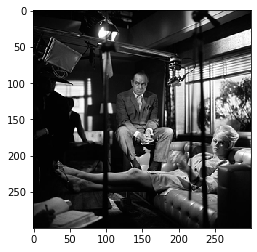

(300, 300, 3)
photograph of the sign being repaired by brave person


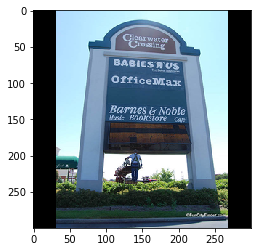

(300, 300, 3)
the player staring intently at a computer screen .


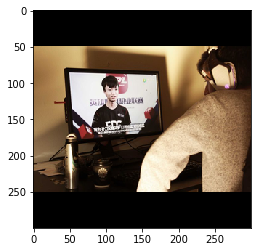

(300, 300, 3)
globes : the green 3d person carrying in hands globe


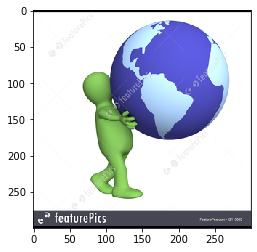

In [197]:
retrieve()